In [1]:
import pandas as pd
import os
import ultraplot as pplt
import numpy as np

# Define the area bin edges
bins = np.logspace(1, 4, base=10, num=20)
plot_range = (4.5, 13.5)

#### Load the rotation data ######
# First need to run the julia script rotation_test_floe_shapes.jl
data = []
for fname in os.listdir('../data/rotation_test/'):
    if '.csv' in fname:
        df = pd.read_csv('../data/rotation_test/' + fname)
        df['case'] = fname.split('-')[0].replace('.csv', '')
        if len(df) > 0:
            data.append(df)
df_all = pd.concat(data)
df_all['floe_id'] = [cn + '_' + str(f).zfill(4) for cn, f in zip(
                                df_all['case'], df_all['floe_id'])]
df_all = df_all.loc[df_all.area > 50]
df_all["L"] = np.sqrt(df_all.area)

df_max = df_all[['floe_id', 'minimum_shape_difference']].groupby('floe_id').max()
df_min = df_all[['floe_id', 'psi_s_correlation']].groupby('floe_id').min()
df_min.columns = df_min.add_prefix('min_', axis=1).columns
df_init = df_all.loc[df_all.rotation==0, ['floe_id', 'area', 'perimeter']].set_index('floe_id')
df_rotation = pd.merge(df_init, df_min, left_index=True, right_index=True).merge(df_max, left_index=True, right_index=True)

# df_rotation['length_bin'] = np.digitize(df_rotation['L'], bins)
df_rotation['area_bin'] = np.digitize(df_rotation['area'], bins)

# Divide into testing and training datasets
training_idx = df_rotation.sample(frac=2/3, random_state=4203).sort_index().index
df_rotation['training'] = False
df_rotation.loc[training_idx, 'training'] = True
df_rotation['normalized_shape_difference'] = df_rotation['minimum_shape_difference'] / df_rotation['perimeter']
rotation_bin_count = df_rotation.loc[training_idx, :][['area_bin', 'area']].groupby('area_bin').mean()
rotation_bin_count['count'] = df_rotation.loc[training_idx, :][['area_bin', 'area']].groupby('area_bin').count()['area']

#### Load the matched pairs data ######
# First need to run the julia script matched_pairs_test_floe_shapes.jl
data = []
for fname in os.listdir('../data/matched_pairs_test/'):
    if '.csv' in fname:
        df = pd.read_csv('../data/matched_pairs_test/' + fname)
        df['case'] = fname.split('-')[0].replace('.csv', '')
        if len(df) > 0:
            data.append(df)
df_matched = pd.concat(data)
df_matched['floe_id'] = [cn + '_' + str(f).zfill(4) for cn, f in zip(
                                df_matched['case'], df_matched['aqua_label'])]
df_matched['area'] = df_matched[['aqua_area', 'terra_area']].mean(axis=1)
df_matched['perimeter'] = df_matched[['aqua_perimeter', 'terra_perimeter']].mean(axis=1)
df_matched['normalized_shape_difference'] = df_matched['minimum_shape_difference'] / df_matched['perimeter']
df_matched = df_matched.loc[df_matched.area > 50]
df_matched["L"] = np.sqrt(df_matched.area)

df_matched['area_bin'] = np.digitize(df_matched['area'], bins)

# Divide into testing and training datasets
training_idx = df_matched.sample(frac=2/3, random_state=4203).sort_index().index
df_matched['training'] = False
df_matched.loc[training_idx, 'training'] = True

matched_bin_count = df_matched.loc[training_idx, :][['area_bin', 'area']].groupby('area_bin').mean()
matched_bin_count['count'] = df_matched.loc[training_idx, :][['area_bin', 'area']].groupby('area_bin').count()['area']

#### Plot ####
fig, axs = pplt.subplots(width=8, height=6, nrows=2, share=False, ncols=2)
h = []

for ax, var, color, dataframe, bin_counts in zip(
        axs,
        ['min_psi_s_correlation', 'normalized_shape_difference', 'psi_s_correlation', 'normalized_shape_difference'],
        ['light gray', 'light gray', 'light gray', 'light gray'],
        [df_rotation.loc[df_rotation.training, :], df_rotation.loc[df_rotation.training, :],
         df_matched.loc[df_matched.training, :], df_matched.loc[df_matched.training, :]],
        [rotation_bin_count, rotation_bin_count, matched_bin_count, matched_bin_count]):

    plot_data = dataframe.pivot_table(columns='area_bin', values=var, index=dataframe.index)
    plot_data = plot_data.loc[:, bin_counts['count'] > 10]
    x = plot_data.columns.astype(int)
    ax.box(plot_data, fillcolor=color, showfliers=True, marker='.', markersize=1, widths=0.2)

    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
    ax.format(xtickminor=False, 
              xlocator=x, xlim=plot_range,
              xformatter=[str(int(x)) for x in bin_counts.area.round().values.squeeze()], xrotation=0,
              xlabel='Bin-average floe area (pixels)',
              xgrid=False, abc=True)

axs[0,0].format(ylabel=r'$\psi-s$ Correlation', title='Minimum Correlation Under Rotation', ylim=(0.49, 1.01))
axs[1,0].format(ylabel=r'$\psi-s$ Correlation', title='Correlation Between Matched Pairs', ylim=(0.49, 1.01))
axs[0,1].format(ylabel='Normalized Shape Difference', title='Max. Optimal Shape Difference Under Rotation', ylim=(-0.02, 1.02))
axs[1,1].format(ylabel='Normalized Shape Difference', title='Optimal Shape Difference Between Matched Pairs', ylim=(-0.03, 3.03))
fig.save('../figures/fig_XX_correlation_shape_difference.png', dpi=300)

ImportError: Unable to import required dependencies:
numpy: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.

For the rotation results, there's a pretty obvious change after the 154 bin. The 95% correlation is often violated for the small floes, and likely is a function of the number of parameterized edge vertices.

In [177]:
np.abs(df_matched['rotation_estimated']).quantile(0.5)

np.float64(5.0)

(array([ 19.,   7.,   6.,   5.,   0.,   6.,   5.,   9.,  11.,   6.,   8.,
          8.,   6.,  19.,   3.,   7.,  10.,  16.,  24.,   7.,  22.,  33.,
         43.,  52.,  20., 342.,  32.,  32.,  32.,  14.,  24.,  28.,  14.,
         18.,   7.,  12.,   8.,   9.,  12.,   5.,   5.,   7.,   7.,   6.,
          2.,   1.,   5.,  11.,   9.,  10.]),
 array([-45. , -43.2, -41.4, -39.6, -37.8, -36. , -34.2, -32.4, -30.6,
        -28.8, -27. , -25.2, -23.4, -21.6, -19.8, -18. , -16.2, -14.4,
        -12.6, -10.8,  -9. ,  -7.2,  -5.4,  -3.6,  -1.8,   0. ,   1.8,
          3.6,   5.4,   7.2,   9. ,  10.8,  12.6,  14.4,  16.2,  18. ,
         19.8,  21.6,  23.4,  25.2,  27. ,  28.8,  30.6,  32.4,  34.2,
         36. ,  37.8,  39.6,  41.4,  43.2,  45. ]),
 <BarContainer object of 50 artists>)

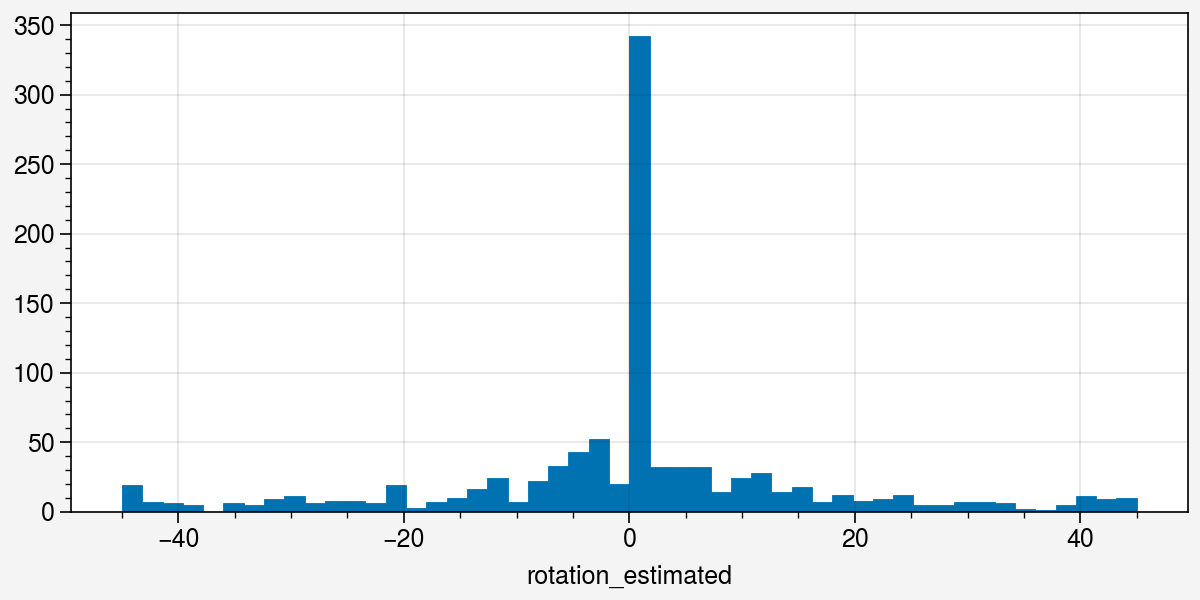

In [160]:
fig, ax = pplt.subplots(width=6, height=3)
ax.hist(df_matched['rotation_estimated'], bins=50)

,psi_s_correlation,area
area_bin,,
5,0.9770,55.50
6,0.9800,73.00
7,0.9735,105.00
8,0.9770,150.00
9,0.9820,216.00
10,0.9855,316.25
11,0.9890,451.00
12,0.9890,654.00
13,0.9880,936.50


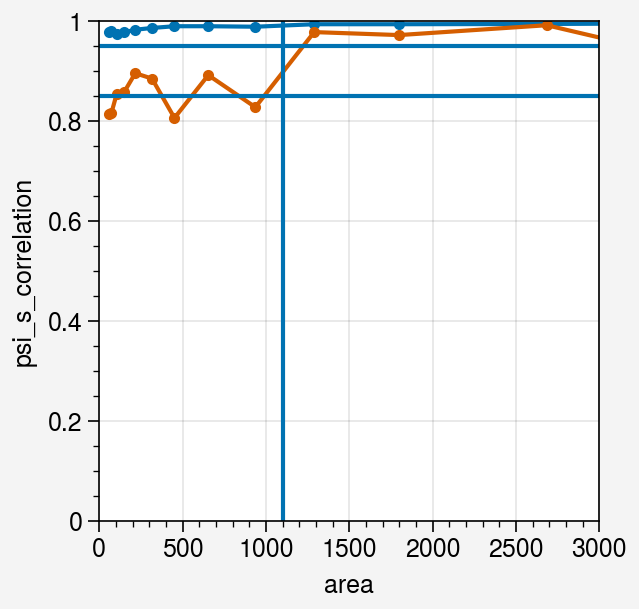

In [193]:
fig, ax = pplt.subplots()
q50 = df_matched.loc[df_matched.training, ['psi_s_correlation', 'area_bin', 'area']].groupby('area_bin').quantile(0.5)
ax.plot(q50.area, q50.psi_s_correlation, marker='.')
q01 = df_matched.loc[df_matched.training, ['psi_s_correlation', 'area_bin', 'area']].groupby('area_bin').quantile(0.01)
ax.plot(q50.area, q01.psi_s_correlation, marker='.')
ax.format(xlim=(0, 3000), ylim=(0, 1))
ax.axhline(0.95)
ax.axhline(0.85)
ax.axvline(1100)
q50

In [136]:
y = plot_data.median(axis=0).loc[5:13]
x = bin_counts.area.loc[5:13]
results = linregress(x, y)
results

LinregressResult(slope=np.float64(0.00048294733344833585), intercept=np.float64(0.562310558254232), rvalue=np.float64(0.9250949050239683), pvalue=np.float64(0.0003517773692465235), stderr=np.float64(7.492835795837342e-05), intercept_stderr=np.float64(0.033053748539388354))

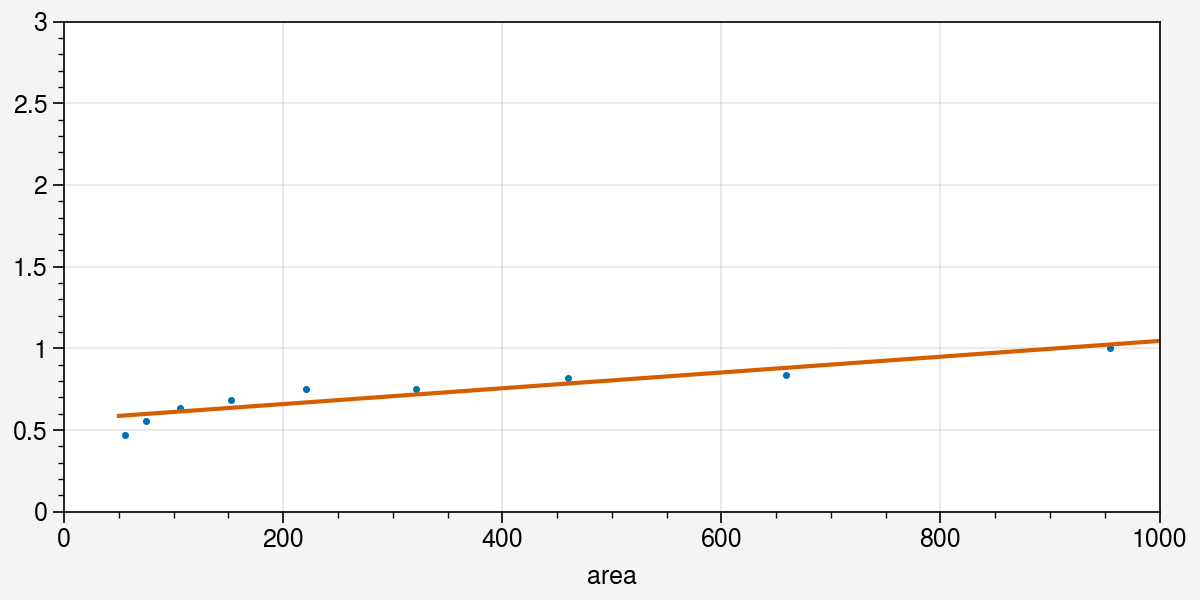

In [138]:
fig, ax = pplt.subplots(width=6, height=3)
ax.scatter(x, y, marker='.', ms=15)
xp = np.linspace(50, 1000, 100)
ax.plot(xp, results.slope * xp + results.intercept)
ax.format(xlim=(0, 1000), ylim=(0, 3))

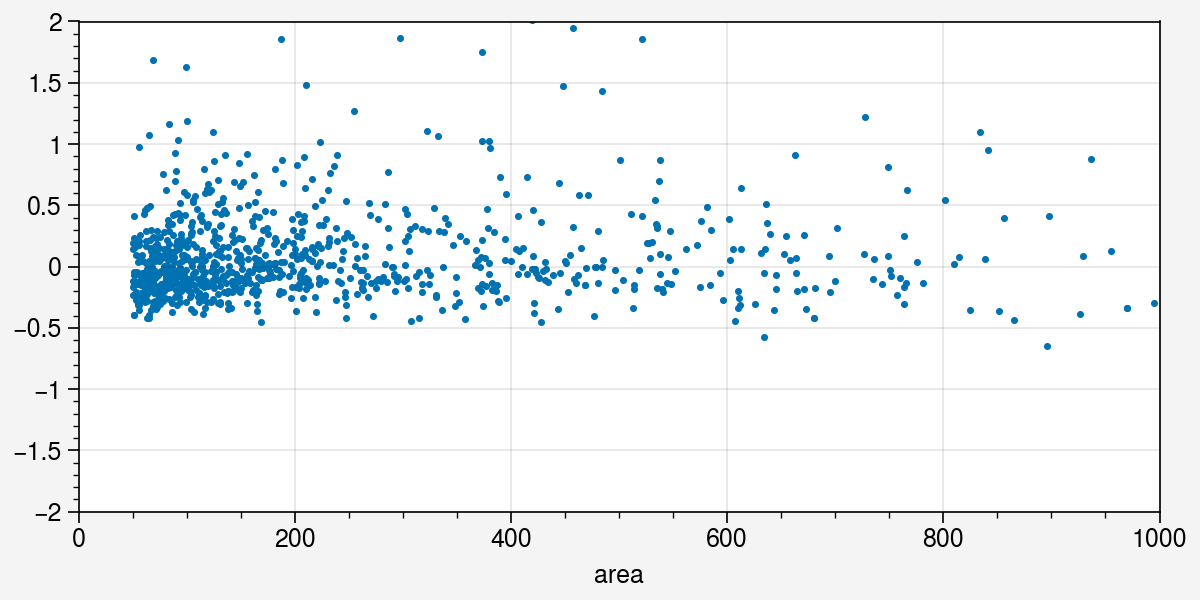

In [142]:
fig, ax = pplt.subplots(width=6, height=3)
xp = df_matched.loc[df_matched.training, 'area']
ax.scatter(df_matched.loc[df_matched.training, 'area'], 
           df_matched.loc[df_matched.training, 'normalized_shape_difference'] - (results.slope * xp + results.intercept), marker='.', ms=15)
ax.format(xlim=(0, 1000), ylim=(-2, 2))

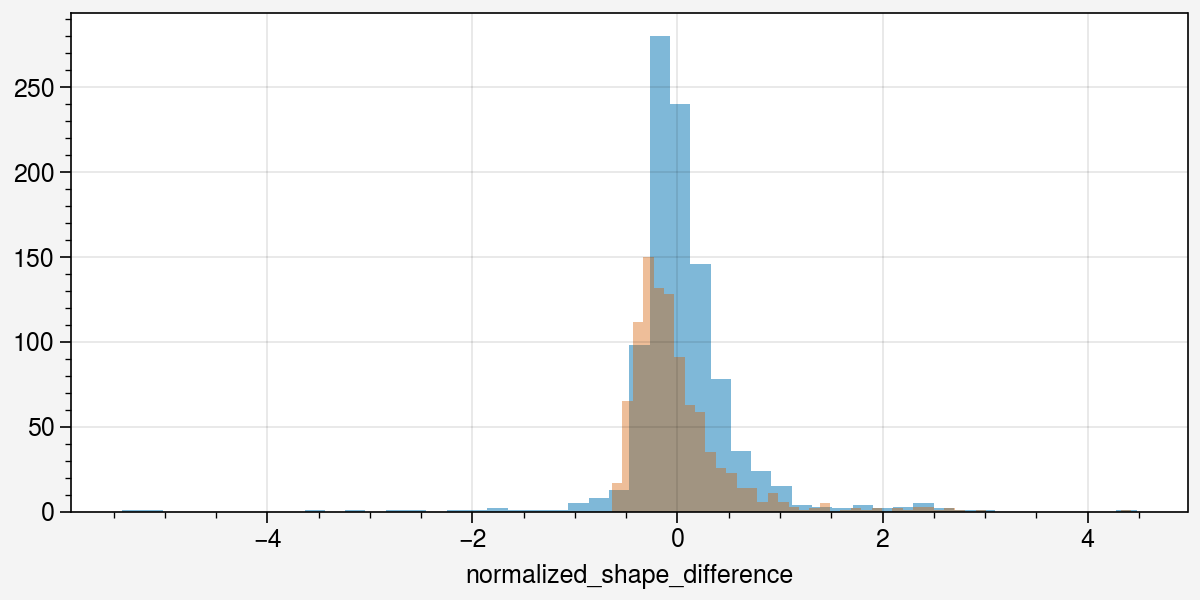

In [149]:
fig, ax = pplt.subplots(width=6, height=3)
_ = ax.hist(df_matched.loc[df_matched.training, 'normalized_shape_difference'] - (results.slope * xp + results.intercept), bins=50, alpha=0.5)
_ = ax.hist(df_matched.loc[df_matched.training, 'normalized_shape_difference'] - df_matched.loc[df_matched.training, 'normalized_shape_difference'].mean(), bins=50, alpha=0.4)

In [6]:
df['normalized_sd'] = df['minimum_shape_difference'] / df['perimeter']
df['normalized_sd_area']  = df['minimum_shape_difference'] / df['area']

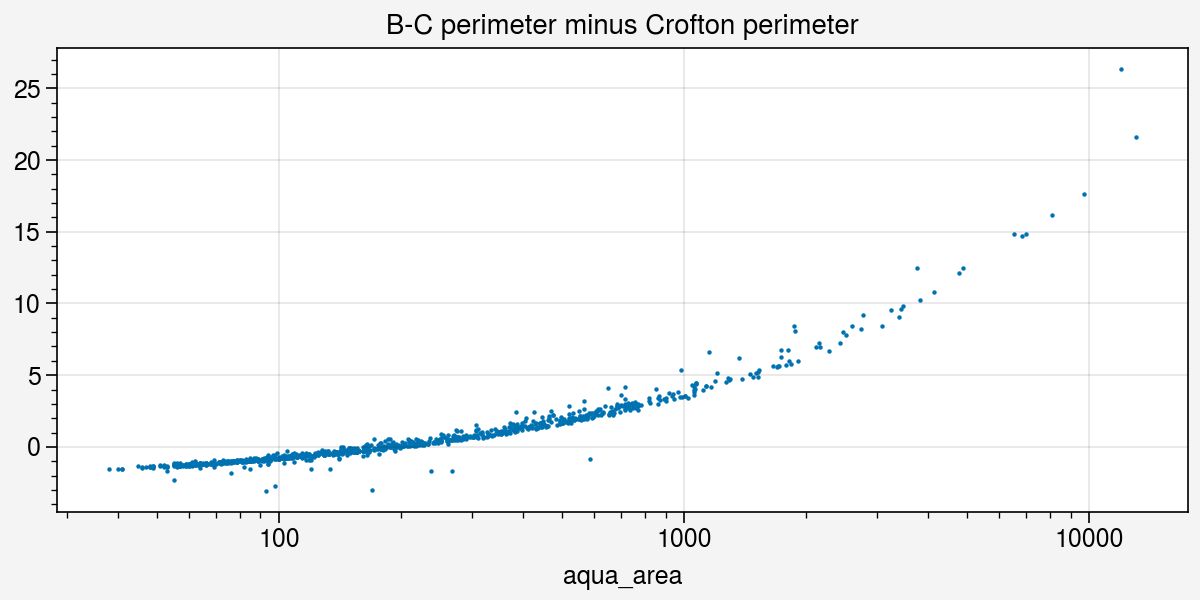

In [90]:
fig, ax = pplt.subplots(width=6, height=3)
ax.scatter(df_matched['aqua_area'], df_matched['aqua_perimeter']-df_matched['aqua_perimeter_crofton'], marker='.', ms=4)
ax.format(xscale='log', title='B-C perimeter minus Crofton perimeter')

The Crofton perimeter is larger than the Benkrid-Crookes perimeter for floes smaller than ~200 pixels, and smaller after that. I'll have to check whether it does indeed correct the issue I saw with circles earlier. It's possible that it does.

In [89]:
8**2*np.pi

201.06192982974676

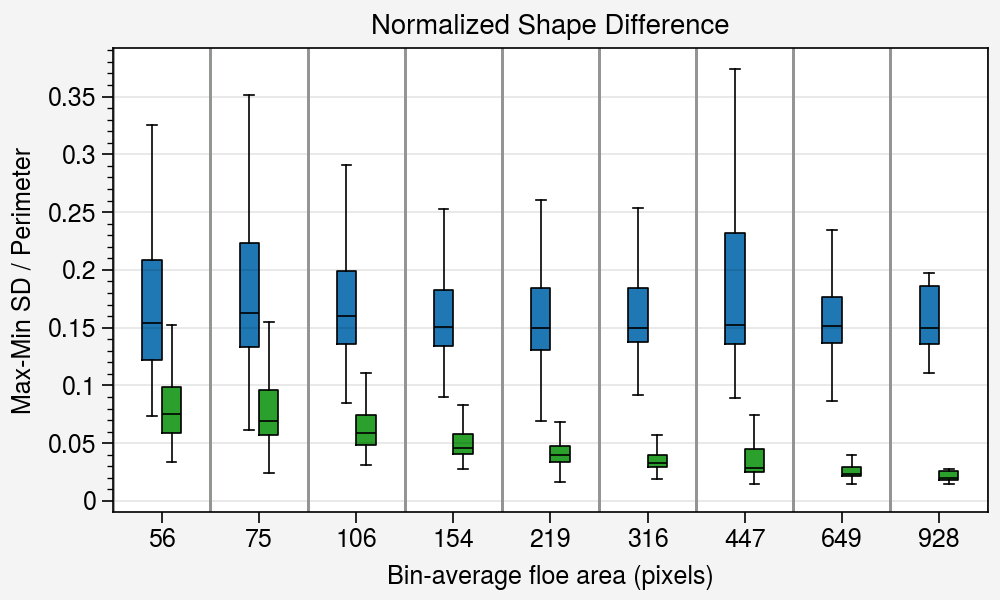

In [7]:
#### Plot ####
fig, axs = pplt.subplots(width=5, height=3, nrows=1, share=False)
ax = axs[0]
h = []
for var, color, offset in zip(['normalized_sd', 'normalized_sd_area'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'], [-0.1, 0.1]):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_count['count'] > 10]
    plot_data.columns += offset
    x = plot_data.columns.astype(int)
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, #ylim=(0.75, 1),
          xformatter=[str(int(x)) for x in bin_count.area.round().values.squeeze()], xrotation=0,
         title='Normalized Shape Difference', xlabel='Bin-average floe area (pixels)', ylabel='Max-Min SD / Perimeter',
         xgrid=False)

## TBD
I'll need to write a Julia script to compute the psi-s correlation and minimum shape difference for the matched pairs.

The perimeter and area are both obvious choices for normalizing the shape difference. The perimeter is more uncertain, because of algorithm issues, but the normalized SD with area decreases with area. It looks like under rotation with this dataset, normalizing by the perimeter is approximately constant, so we could use a single threshold. A future update could interpret it probabilistically too, giving each observation a Z-score.

In [8]:
#### Load the data both for the matches and for the inital images #####
dataloc = '/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/ice_floe_validation_dataset/data/validation_dataset/'

files = os.listdir(dataloc + 'property_tables/matched/')
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + 'property_tables/matched/' + f))
df_matched = pd.concat(data)

files = os.listdir(dataloc + '/property_tables/aqua/')
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + '/property_tables/aqua/' + f))
df_aqua = pd.concat(data)


files = os.listdir(dataloc + '/property_tables/terra/')
data = []
for f in files:
    if '.csv' in f:
        data.append(pd.read_csv(dataloc + '/property_tables/terra/' + f))
df_terra = pd.concat(data)

df_matched = df_matched.dropna()
df_matched['case_number'] = [str(int(x)).zfill(3) for x in df_matched['case_number']]
df_terra['case_number'] = [str(int(x)).zfill(3) for x in df_terra['case_number']]
df_aqua['case_number'] = [str(int(x)).zfill(3) for x in df_aqua['case_number']]

df_merged = df_matched.merge(df_aqua[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['aqua_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_aqua'], how='inner').merge(
    df_terra[['label', 'case_number', 'axis_major_length', 'axis_minor_length', 'convex_area']], 
                 left_on=['terra_label', 'case_number'], right_on=['label', 'case_number'],
                 suffixes=[None, '_terra'], how='inner')
df_merged.rename({'axis_major_length': 'axis_major_length_aqua',
                  'axis_minor_length': 'axis_minor_length_aqua',
                  'aqua_area': 'area_aqua',
                  'terra_area': 'area_terra',
                  'convex_area': 'convex_area_aqua'}, axis=1, inplace=True)

#### Compute ADRs ####
df_merged['adr_area'] = np.abs(df_merged['area_aqua'] - df_merged['area_terra'])/(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['adr_major_axis_length'] = np.abs(df_merged['axis_major_length_aqua'] - df_merged['axis_major_length_terra'])/(df_merged['axis_major_length_aqua'] + df_merged['axis_major_length_terra'])
df_merged['adr_minor_axis_length'] = np.abs(df_merged['axis_minor_length_aqua'] - df_merged['axis_minor_length_terra'])/(df_merged['axis_minor_length_aqua'] + df_merged['axis_minor_length_terra'])
df_merged['adr_convex_area'] = np.abs(df_merged['convex_area_aqua'] - df_merged['convex_area_terra'])/(df_merged['convex_area_aqua'] + df_merged['convex_area_terra'])

df_merged['area'] = 1/2*(df_merged['area_aqua'] + df_merged['area_terra'])
df_merged['L'] = np.sqrt(df_merged['area'])
df_merged['area_bin'] = np.digitize(df_merged['area'], bins)

df_merged = df_merged.loc[df_merged.area > 50].copy()
merged_bin_count = df_merged[['area_bin', 'area']].groupby('area_bin').mean()
merged_bin_count['count'] = df_merged[['area_bin', 'area']].groupby('area_bin').count()['area']

# Divide into testing and training datasets
training_idx = df_merged.sample(frac=2/3, random_state=4204).sort_index().index
df_merged['training'] = False
df_merged.loc[training_idx, 'training'] = True

# could make this a function
df_mg = df_merged.loc[training_idx, :].copy()

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_46691/3084273253.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aqua = pd.concat(data)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_46691/3084273253.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_terra = pd.concat(data)


In [ ]:
#### Plot ####
fig, axs = pplt.subplots(width=5, height=6, nrows=2, share=False)
ax = axs[0]
h = []
for var, color, offset in zip(['max_adr_area', 'max_adr_convex_area',
                       'max_adr_major_axis_length', 'max_adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):
    plot_data = df.pivot_table(columns='area_bin', values=var, index=df.index)
    plot_data = plot_data.loc[:, bin_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))

    # Draw grid lines
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, ylim=(0, 0.3),
          xformatter=[str(int(x)) for x in bin_count.area.round().values.squeeze()], xrotation=0,
         title='Rotation', xlabel='Bin-average floe area (pixels)', ylabel='ADR',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
# fig.save('../figures/maximum_adr_rotation_boxplot.png', dpi=300)


# fig, ax = pplt.subplots(width=6, height=3)
ax = axs[1]
h = []
for var, color, offset in zip(['adr_area', 'adr_convex_area', 'adr_major_axis_length', 'adr_minor_axis_length'],
                      ['tab:blue', 'tab:green', 'tab:orange', 'tab:gray'],
                             np.linspace(-0.3, 0.3, 4)):

    merged_bin_count = df_mg[['area_bin', 'area']].groupby('area_bin').mean()
    merged_bin_count['count'] = df_mg[['area_bin', 'area']].groupby('area_bin').count()['area']

    plot_data = df_mg.pivot_table(columns='area_bin', values=var, index=df_mg.index)
    plot_data = plot_data.loc[:, merged_bin_count['count'] > 10]
    x = plot_data.columns.astype(int)
    plot_data.columns = plot_data.columns + offset
    ax.box(plot_data, fillcolor=color, showfliers=False, widths=0.2)
    h.append(ax.plot([],[], m='s', c=color, lw=0, ec='k'))
    for xc in x[:-1]:
        ax.axvline(xc + 0.5, lw=1, color='gray')
        
ax.format(xtickminor=False, #xlocator=bin_area_ave.round().values.squeeze(),
          xlocator=x, xlim=plot_range, ylim=(0, 0.3),
          xformatter=[str(int(x)) for x in merged_bin_count.area.round(1).values.squeeze()], xrotation=0,
         title='Matched Pairs', xlabel='Bin-average floe area (pixels)', ylabel='ADR',
         xgrid=False)

ax.legend(h, ['Area', 'Convex Area', 'Major Axis Length', 'Minor Axis Length'], ncols=1)
fig.format(abc=True)
fig.save('../figures/fig_XX_adr_analysis.png', dpi=300)